# Introduction

This Jupyter Notebook demonstrates how one might use the NCAR Community Earth System Model (CESM)
Large Ensemble (LENS) data hosted on AWS S3 ([doi:10.26024/wt24-5j82](https://doi.org/10.26024/wt24-5j82)). The notebook shows how to reproduce figures 2 and 4 from the Kay et al. (2015) paper describing the CESM LENS dataset ([doi:10.1175/BAMS-D-13-00255.1](https://doi.org/10.1175/BAMS-D-13-00255.1))

This resource is intended to be helpful for people not familiar with elements of the [Pangeo](https://pangeo.io) framework including Jupyter Notebooks, [Xarray](http://xarray.pydata.org/), and [Zarr](https://zarr.readthedocs.io/) data format, or with the original paper, so it includes additional explanation.

Notebook version 3.3 (2019 Dec 19)

## Set up environment

In [1]:
# Display output of plots directly in Notebook
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Silence dask.distributed logs
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)
import dask.config
dask.config.set({'distributed.logging.distributed': 'error'})

import intake
import numpy as np
import pandas as pd
import xarray as xr

## Create and Connect to Dask Distributed Cluster

In [2]:
# Create cluster
from dask_kubernetes import KubeCluster
from dask.distributed import Client
cluster = KubeCluster()
cluster.adapt(minimum=2, maximum=100, wait_count=60)
# Connect to cluster
client = Client(cluster)
# Display cluster dashboard URL
cluster


☝️ Link to scheduler dashboard will appear above.

## Load data into xarray from a catalog using intake-esm

- [Intake-esm Documentation](https://intake-esm.readthedocs.io/en/latest/notebooks/tutorial.html)

In [3]:
# Open collection description file
intakeEsmUrl = 'https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json'
col = intake.open_esm_datastore(intakeEsmUrl)
print(col._col_data['description']) #Description of collection
print("Catalog file:", col._col_data['catalog_file'])
print(col) #Summary of collection structure

This is an ESM collection for CESM1 Large Ensemble Zarr dataset publicly available on Amazon S3 (us-west-2 region)
Catalog file: https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.csv
aws-cesm1-le-ESM Collection with 302 entries:
	> 5 component(s)

	> 5 frequency(s)

	> 6 experiment(s)

	> 54 variable(s)

	> 302 path(s)



In [4]:
# Show expanded version of collection structure with details
import pprint
uniques = col.unique(columns=["component", "frequency", "experiment", "variable"])
pprint.pprint(uniques, compact=True, indent=4)

{   'component': {   'count': 5,
                     'values': ['atm', 'ice_nh', 'ice_sh', 'lnd', 'ocn']},
    'experiment': {   'count': 6,
                      'values': [   '20C', 'RCP85', 'CTRL', 'CTRL_AMIP',
                                    'CTRL_SLAB_OCN', 'HIST']},
    'frequency': {   'count': 5,
                     'values': [   'daily', 'hourly6-1990-2005',
                                   'hourly6-2026-2035', 'hourly6-2071-2080',
                                   'monthly']},
    'variable': {   'count': 54,
                    'values': [   'FLNS', 'FLNSC', 'FLUT', 'FSNS', 'FSNSC',
                                  'FSNTOA', 'ICEFRAC', 'LHFLX', 'PRECL',
                                  'PRECSC', 'PRECSL', 'PRECT', 'PRECTMX', 'PSL',
                                  'Q850', 'SHFLX', 'TMQ', 'TREFHT', 'TREFHTMN',
                                  'TREFHTMX', 'TS', 'UBOT', 'WSPDSRFAV', 'Z500',
                                  'PS', 'Q', 'QREFHT', 'T', 'U', 'V', 'Z3',

In [5]:
# Show the first few lines of the catalog
col.df.head(10)

,component,frequency,experiment,variable,path
0,atm,daily,20C,FLNS,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLNS....
1,atm,daily,20C,FLNSC,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLNSC...
2,atm,daily,20C,FLUT,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLUT....
3,atm,daily,20C,FSNS,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FSNS....
4,atm,daily,20C,FSNSC,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FSNSC...
5,atm,daily,20C,FSNTOA,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FSNTO...
6,atm,daily,20C,ICEFRAC,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-ICEFR...
7,atm,daily,20C,LHFLX,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-LHFLX...
8,atm,daily,20C,PRECL,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-PRECL...
9,atm,daily,20C,PRECSC,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-PRECS...


In [6]:
# Optional: inspect the collection object
#import inspect
#inspect.getmembers(col)

## Extract data needed to construct Figure 2 of Kay et al. paper

In [7]:
# Search the catalog to find the desired data, in this case the reference height temperature
# of the atmosphere, at daily time resolution, for the Historical, 20th Century, and RCP8.5 (IPCC
# Representative Concentration Pathway 8.5) experiments
col_subset = col.search(frequency=["daily", "monthly"], component="atm", variable="TREFHT", 
                        experiment=["20C", "RCP85", "HIST"])
print("Data subset:")
col_subset.df

Data subset:


,component,frequency,experiment,variable,path
0,atm,daily,20C,TREFHT,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-TREFH...
1,atm,daily,RCP85,TREFHT,s3://ncar-cesm-lens/atm/daily/cesmLE-RCP85-TRE...
2,atm,monthly,20C,TREFHT,s3://ncar-cesm-lens/atm/monthly/cesmLE-20C-TRE...
3,atm,monthly,HIST,TREFHT,s3://ncar-cesm-lens/atm/monthly/cesmLE-HIST-TR...
4,atm,monthly,RCP85,TREFHT,s3://ncar-cesm-lens/atm/monthly/cesmLE-RCP85-T...


In [8]:
# Load catalog entries for subset into a dictionary of xarray datasets
dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})
print("\nDataset dictionary keys:\n", dsets.keys())

Progress: |-------------------------------------------------------------------------------| 0.0% 

Progress: |████████████████---------------------------------------------------------------| 20.0% 

Progress: |████████████████████████████████-----------------------------------------------| 40.0% 

Progress: |███████████████████████████████████████████████--------------------------------| 60.0% 

Progress: |███████████████████████████████████████████████████████████████----------------| 80.0% 

Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'
             
--> There are 5 group(s)

Dataset dictionary keys:
 dict_keys(['atm.20C.monthly', 'atm.HIST.monthly', 'atm.RCP85.monthly', 'atm.RCP85.daily', 'atm.20C.daily'])


In [9]:
# Define Xarray datasets corresponding to the three experiments
ds_HIST = dsets['atm.HIST.monthly']
ds_20C = dsets['atm.20C.daily']
ds_RCP85 = dsets['atm.RCP85.daily']

In [10]:
# Use Dask.Distributed utility function to display size of each dataset
from distributed.utils import format_bytes
print("\n",
      "Historical:", format_bytes(ds_HIST.nbytes), "\n",
      "20th Century:", format_bytes(ds_20C.nbytes), "\n",
      "RCP8.5:", format_bytes(ds_RCP85.nbytes))


 Historical: 186.12 MB 
 20th Century: 277.72 GB 
 RCP8.5: 306.79 GB


In [11]:
# Extract the Reference Height Temperature data variable
t_hist = ds_HIST["TREFHT"]
t_20c = ds_20C["TREFHT"]
t_rcp = ds_RCP85["TREFHT"]
print("Description of 20C data:\n", t_20c)

Description of 20C data:
 <xarray.DataArray 'TREFHT' (member_id: 40, time: 31390, lat: 192, lon: 288)>
dask.array<zarr, shape=(40, 31390, 192, 288), dtype=float32, chunksize=(2, 365, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time       (time) object 1920-01-01 00:00:00 ... 2005-12-31 00:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Reference height temperature
    units:         K


In [12]:
# The global surface temperature anomaly was computed relative to the 1961-90 base period
# in the Kay et al. paper, so extract that time slice
t_ref = t_20c.sel(time=slice("1961", "1990"))

## Read grid cell areas
Cell size varies with latitude, so this must be accounted for when computing the global mean.

Note: Each Zarr store includes area values and other ancillary information in addition to the
actual data. A possible optimization to reduce data size would be to extract the duplicated
information into separate objects.

In [13]:
cell_area = ds_20C.area
total_area = cell_area.sum()
cell_area

<xarray.DataArray 'area' (lat: 192, lon: 288)>
dask.array<zarr, shape=(192, 288), dtype=float32, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    long_name:      Grid-Cell Area
    standard_name:  cell_area
    units:          m2

## Define Weighted Means
Note: resample(time="AS") does an Annual resampling based on Start of calendar year.
See documentation for [Pandas resampling options](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)

In [14]:
t_ref_ts = (
    (t_ref.resample(time="AS").mean("time") * cell_area).sum(dim=("lat", "lon"))
    / total_area
).mean(dim=("time", "member_id"))

t_hist_ts = (
    (t_hist.resample(time="AS").mean("time") * cell_area).sum(dim=("lat", "lon"))
) / total_area

t_20c_ts = (
    (t_20c.resample(time="AS").mean("time") * cell_area).sum(dim=("lat", "lon"))
) / total_area

t_rcp_ts = (
    (t_rcp.resample(time="AS").mean("time") * cell_area).sum(dim=("lat", "lon"))
) / total_area

## Read data and compute means
Note: Pangeo's "lazy execution" philosophy means that until this point we have not actually read the bulk of the data. These steps take a while to complete, so we include the Notebook "cell magic" directive %%time to display elapsed and CPU times after computation.

In [15]:
%%time
t_ref_mean = t_ref_ts.load()
t_ref_mean

CPU times: user 12.3 s, sys: 907 ms, total: 13.2 s
Wall time: 6min 23s


<xarray.DataArray ()>
array(286.38766, dtype=float32)

In [16]:
%%time
t_hist_ts_df = t_hist_ts.to_series().T
t_hist_ts_df.head()

CPU times: user 747 ms, sys: 36.4 ms, total: 784 ms
Wall time: 5.67 s


time
1850-01-01 00:00:00    286.372620
1851-01-01 00:00:00    286.280853
1852-01-01 00:00:00    286.260742
1853-01-01 00:00:00    286.218781
1854-01-01 00:00:00    286.159119
dtype: float32

In [17]:
%%time
t_20c_ts_df = t_20c_ts.to_series().unstack().T
t_20c_ts_df.head()

CPU times: user 25.5 s, sys: 1.01 s, total: 26.5 s
Wall time: 1min 53s


member_id,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,101,102,103,104,105
time,,,,,,,,,,,,,,,,,,,,,
1920-01-01 00:00:00,286.311310,286.346710,286.283875,286.363983,286.328400,286.373444,286.386017,286.302185,286.374878,286.348358,...,286.243469,286.283783,286.173859,286.309509,286.296234,286.341064,286.341187,286.376831,286.321167,286.254822
1921-01-01 00:00:00,286.250641,286.198181,286.287292,286.390564,286.309204,286.334229,286.311310,286.300232,286.315857,286.305603,...,286.179413,286.315674,286.075104,286.295990,286.318085,286.375275,286.246063,286.356201,286.492523,286.224274
1922-01-01 00:00:00,286.293488,286.296356,286.265686,286.336517,286.293579,286.220093,286.010773,286.195099,286.205170,286.396545,...,286.142365,286.316254,286.140167,286.293549,286.327972,286.142365,286.412598,286.369232,286.503418,286.282074
1923-01-01 00:00:00,286.329163,286.322662,286.251099,286.322723,286.237457,286.152069,286.066040,286.204498,286.271454,286.292236,...,286.168762,286.300781,286.095490,286.116302,286.227905,286.226440,286.512909,286.381348,286.215302,286.396332
1924-01-01 00:00:00,286.307465,286.237366,286.148895,286.311890,286.361694,286.185974,286.248352,286.288177,286.330444,286.411835,...,286.143066,286.287079,286.234100,286.199890,286.252777,286.322815,286.256165,286.221588,286.247437,286.422028


In [18]:
%%time
t_rcp_ts_df = t_rcp_ts.to_series().unstack().T
t_rcp_ts_df.head()

CPU times: user 23.6 s, sys: 917 ms, total: 24.5 s
Wall time: 57.7 s


member_id,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,101,102,103,104,105
time,,,,,,,,,,,,,,,,,,,,,
2006-01-01 00:00:00,286.764832,286.960358,286.679230,286.793152,286.754547,287.022339,286.850464,287.089844,286.960022,286.775787,...,286.866089,286.925049,286.663971,286.955414,286.712524,287.115601,286.863556,286.881683,287.308411,287.030334
2007-01-01 00:00:00,287.073792,286.908539,286.808746,286.998901,286.841675,286.993042,286.914124,286.938965,286.933563,286.675385,...,286.804108,286.849548,286.628204,287.010529,286.811523,287.187225,286.862823,287.008240,287.222534,287.239044
2008-01-01 00:00:00,287.104095,286.815033,286.995056,287.081543,287.100708,286.960510,286.854706,286.878937,287.062927,286.702454,...,286.825653,286.844086,286.811859,286.803741,286.956635,287.080994,286.930084,286.945801,287.087128,287.157745
2009-01-01 00:00:00,286.984497,287.059418,287.010498,287.144745,286.948700,287.092316,286.888458,287.050964,287.138428,286.890839,...,286.785797,286.876556,286.953094,287.060364,287.056885,287.124908,287.005615,287.083984,287.254211,287.060730
2010-01-01 00:00:00,286.991821,287.102295,286.988159,286.875183,286.954407,287.121796,286.938843,287.116211,286.957245,287.049622,...,286.937317,286.928284,286.980499,287.118713,287.178040,287.030212,287.114716,287.083038,287.256927,287.066528


## Get Observations for Figure 2 (HadCRUT4; Morice et al. 2012)

In [19]:
# Observational time series data for comparison with ensemble average
obsDataURL = "https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/cru/hadcrut4/air.mon.anom.median.nc"

In [20]:
ds = xr.open_dataset(obsDataURL).load()
ds

<xarray.Dataset>
Dimensions:    (lat: 36, lon: 72, nbnds: 2, time: 2042)
Coordinates:
  * lat        (lat) float32 87.5 82.5 77.5 72.5 ... -72.5 -77.5 -82.5 -87.5
  * lon        (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2020-02-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] 1850-01-01 1850-01-31 ... 2020-02-28
    air        (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    platform:                        Surface
    title:                           HADCRUT4 Combined Air Temperature/SST An...
    history:                         Originally created at NOAA/ESRL PSD by C...
    Conventions:                     CF-1.0
    Comment:                         This dataset supersedes V3
    Source:                          Obtained from http://hadobs.metoffice.co...
    version:                         4.2.0
    dataset_title:                   HadCRUT4
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    DODS_EXTRA.Unlimited_Dimension:  time

- **Obs mean: weight by days in each month**

In [21]:
def weighted_temporal_mean(ds):
    time_bound_diff = ds.time_bnds.diff(dim="nbnds")[:, 0]
    wgts = time_bound_diff.groupby("time.year") / time_bound_diff.groupby(
        "time.year"
    ).sum(xr.ALL_DIMS)
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)
    obs = ds["air"]
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")
    obs_s = (obs_sum / ones_out).mean(("lat", "lon")).to_series()
    return obs_s

- **Limit Observations to 20th Century**

In [22]:
obs_s = weighted_temporal_mean(ds)
obs_s = obs_s['1920':]
obs_s.head()

time
1920-01-01   -0.262006
1921-01-01   -0.195891
1922-01-01   -0.301986
1923-01-01   -0.269062
1924-01-01   -0.292857
Freq: AS-JAN, dtype: float64

In [23]:
all_ts_anom = pd.concat([t_20c_ts_df, t_rcp_ts_df]) - t_ref_mean.data
years = [val.year for val in all_ts_anom.index]
obs_years = [val.year for val in obs_s.index]

In [24]:
# Combine ensemble member 1 data from historical and 20th century experiments
hist_anom = t_hist_ts_df - t_ref_mean.data
member1 = pd.concat([hist_anom.iloc[:-2], all_ts_anom.iloc[:,0]], verify_integrity=True)
member1_years = [val.year for val in member1.index]

## Figure 2: Global surface temperature anomaly (1961-90 base period) for individual ensemble members, and observations

In [25]:
import matplotlib.pyplot as plt

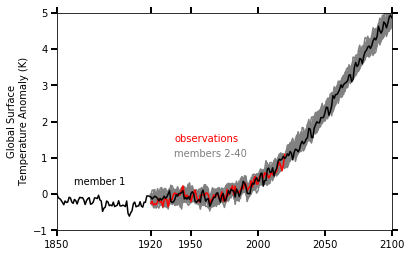

In [26]:
ax = plt.axes()

ax.tick_params(right=True, top=True, direction="out", length=6, width=2, grid_alpha=0.5)
ax.plot(years, all_ts_anom.iloc[:,1:], color="grey")
ax.plot(obs_years, obs_s['1920':], color="red")
ax.plot(member1_years, member1, color="black")


ax.text(
    0.35,
    0.4,
    "observations",
    verticalalignment="bottom",
    horizontalalignment="left",
    transform=ax.transAxes,
    color="red",
    fontsize=10,
)
ax.text(
    0.35,
    0.33,
    "members 2-40",
    verticalalignment="bottom",
    horizontalalignment="left",
    transform=ax.transAxes,
    color="grey",
    fontsize=10,
)
ax.text(
    0.05,
    0.2,
    "member 1",
    verticalalignment="bottom",
    horizontalalignment="left",
    transform=ax.transAxes,
    color="black",
    fontsize=10,
)

ax.set_xticks([1850, 1920, 1950, 2000, 2050, 2100])
plt.ylim(-1, 5)
plt.xlim(1850, 2100)
plt.ylabel("Global Surface\nTemperature Anomaly (K)")
plt.show()

Figure will appear above when ready. Compare with Fig.2 of Kay et al. 2015 ([doi:10.1175/BAMS-D-13-00255.1](https://doi.org/10.1175/BAMS-D-13-00255.1))

## Compute Linear Trend for Winter Seasons

In [27]:
def linear_trend(da, dim="time"):
    da_chunk = da.chunk({dim: -1})
    trend = xr.apply_ufunc(
        calc_slope,
        da_chunk,
        vectorize=True,
        input_core_dims=[[dim]],
        output_core_dims=[[]],
        output_dtypes=[np.float],
        dask="parallelized",
    )
    return trend


def calc_slope(y):
    """ufunc to be used by linear_trend"""
    x = np.arange(len(y))

    # drop missing values (NaNs) from x and y
    finite_indexes = ~np.isnan(y)
    slope = np.nan if (np.sum(finite_indexes) < 2) else np.polyfit(x[finite_indexes], y[finite_indexes], 1)[0]
    return slope

### Compute ensemble trends

In [28]:
t = xr.concat([t_20c, t_rcp], dim="time")
seasons = t.sel(time=slice("1979", "2012")).resample(time="QS-DEC").mean("time")
# Include only full seasons from 1979 and 2012
seasons = seasons.sel(time=slice("1979", "2012")).load()


In [29]:
winter_seasons = seasons.sel(
    time=seasons.time.where(seasons.time.dt.month == 12, drop=True)
)
winter_trends = linear_trend(
    winter_seasons.chunk({"lat": 20, "lon": 20, "time": -1})
).load() * len(winter_seasons.time)

# Compute ensemble mean from the first 30 members
winter_trends_mean = winter_trends.isel(member_id=range(30)).mean(dim='member_id')

In [30]:
# Make sure that we have 34 seasons
assert len(winter_seasons.time) == 34

### Get Observations for Figure 4 (NASA GISS GisTemp)

In [31]:
# Observational time series data for comparison with ensemble average
# NASA GISS Surface Temperature Analysis, https://data.giss.nasa.gov/gistemp/
obsDataURL = "https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz"

In [32]:
# Download, unzip, and load file
import os
os.system("wget " + obsDataURL)

obsDataFileName = obsDataURL.split('/')[-1]
os.system("gunzip " + obsDataFileName)

obsDataFileName = obsDataFileName[:-3]
ds = xr.open_dataset(obsDataFileName).load()
ds

<xarray.Dataset>
Dimensions:      (lat: 90, lon: 180, nv: 2, time: 1683)
Coordinates:
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon          (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2020-03-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] 1880-01-01 1880-02-01 ... 2020-04-01
    tempanomaly  (time, lat, lon) float32 nan nan nan nan ... 3.01 3.01 3.01
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2020-04-13 16:23:33 by SBBX_to_nc 2.0 - ILAND=1200,...

In [33]:
# Remap longitude range from [-180, 180] to [0, 360] for plotting purposes
ds = ds.assign_coords(lon=((ds.lon + 360) % 360)).sortby('lon')
ds

<xarray.Dataset>
Dimensions:      (lat: 90, lon: 180, nv: 2, time: 1683)
Coordinates:
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon          (lon) float32 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * time         (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2020-03-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] 1880-01-01 1880-02-01 ... 2020-04-01
    tempanomaly  (time, lat, lon) float32 nan nan nan nan ... 3.01 3.01 3.01
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2020-04-13 16:23:33 by SBBX_to_nc 2.0 - ILAND=1200,...

### Compute observed trends

In [34]:
obs_seasons = ds.sel(time=slice("1979", "2012")).resample(time="QS-DEC").mean("time")
# Include only full seasons from 1979 through 2012
obs_seasons = obs_seasons.sel(time=slice("1979", "2012")).load()

# Compute observed winter trends
obs_winter_seasons = obs_seasons.sel(
    time=obs_seasons.time.where(obs_seasons.time.dt.month == 12, drop=True)
)
obs_winter_seasons

<xarray.Dataset>
Dimensions:      (lat: 90, lon: 180, time: 34)
Coordinates:
  * time         (time) datetime64[ns] 1979-12-01 1980-12-01 ... 2012-12-01
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon          (lon) float32 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
Data variables:
    tempanomaly  (time, lat, lon) float32 0.5333333 0.5333333 ... 7.48 7.48

In [35]:
obs_winter_trends = linear_trend(
    obs_winter_seasons.chunk({"lat": 20, "lon": 20, "time": -1})
).load() * len(obs_winter_seasons.time)
obs_winter_trends

<xarray.Dataset>
Dimensions:      (lat: 90, lon: 180)
Coordinates:
  * lon          (lon) float32 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Data variables:
    tempanomaly  (lat, lon) float64 1.309 1.309 1.309 ... 5.695 5.695 5.695

## Figure 4: Global maps of historical (1979 - 2012) boreal winter (DJF) surface air trends

In [36]:
import cmaps  # for NCL colormaps
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

contour_levels = [-6, -5, -4, -3, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3, 4, 5, 6]

color_map = cmaps.ncl_default

In [37]:
def make_map_plot(nplot_rows, nplot_cols, plot_index, data, plot_label):
    """ Create a single map subplot. """
    ax = plt.subplot(nplot_rows, nplot_cols, plot_index, projection = ccrs.Robinson(central_longitude = 180))
    cplot = plt.contourf(lons, lats, data, 
                         levels = contour_levels, 
                         cmap = color_map, 
                         extend = 'both', 
                         transform = ccrs.PlateCarree())
    ax.coastlines(color = 'grey')
    ax.text(0.01, 0.01, plot_label, fontSize = 14, transform = ax.transAxes)
    return cplot, ax

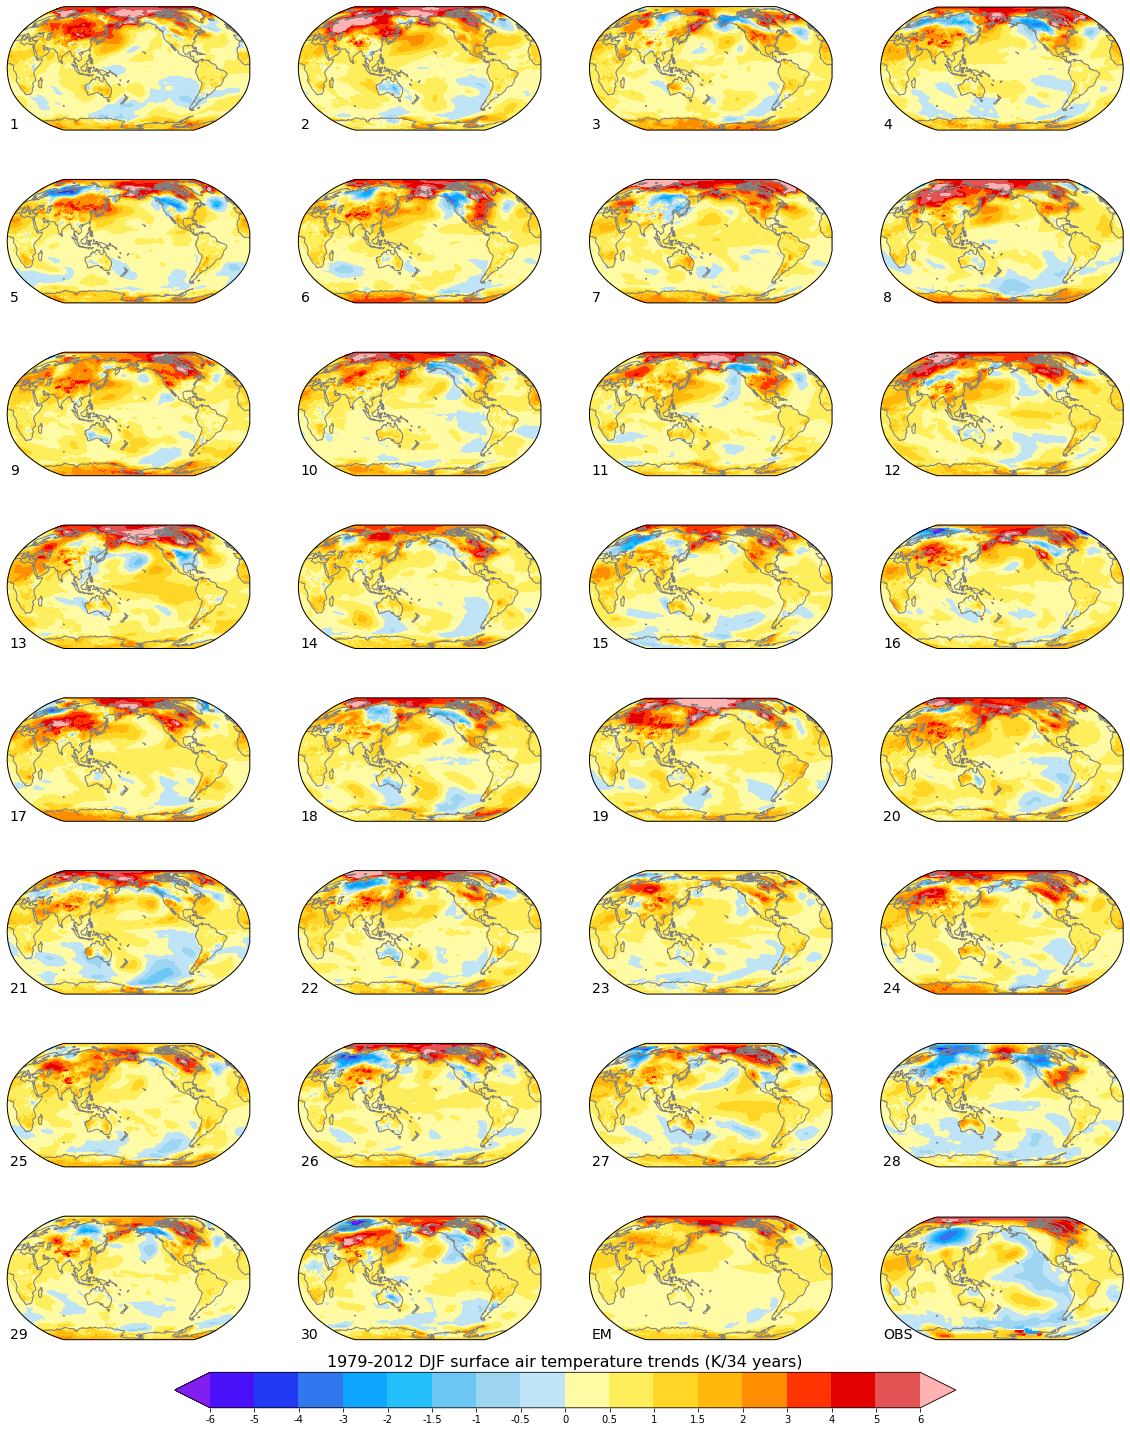

In [38]:
# Generate plot (may take a while as many individual maps are generated)
numPlotRows = 8
numPlotCols = 4
figWidth = 20 
figHeight = 30 
 
fig, axs = plt.subplots(numPlotRows, numPlotCols, figsize=(figWidth,figHeight))

lats = winter_trends.lat
lons = winter_trends.lon

# Create ensemble member plots
for ensemble_index in range(30):
    plot_data = winter_trends.isel(member_id = ensemble_index)
    plot_index = ensemble_index + 1
    plot_label = str(plot_index)
    plotRow = ensemble_index // numPlotCols
    plotCol = ensemble_index % numPlotCols
    # Retain axes objects for figure colorbar
    cplot, axs[plotRow, plotCol] = make_map_plot(numPlotRows, numPlotCols, plot_index, plot_data, plot_label)

# Create plots for the ensemble mean, observations, and a figure color bar.
cplot, axs[7,2] = make_map_plot(numPlotRows, numPlotCols, 31, winter_trends_mean, 'EM')

lats = obs_winter_trends.lat
lons = obs_winter_trends.lon
cplot, axs[7,3] = make_map_plot(numPlotRows, numPlotCols, 32, obs_winter_trends.tempanomaly, 'OBS')  

cbar = fig.colorbar(cplot, ax=axs, orientation='horizontal', shrink = 0.7, pad = 0.02)
cbar.ax.set_title('1979-2012 DJF surface air temperature trends (K/34 years)', fontSize = 16)
cbar.set_ticks(contour_levels)
cbar.set_ticklabels(contour_levels)

Figure will appear above when ready. Compare with Fig. 4 of Kay et al. 2015 ([doi:10.1175/BAMS-D-13-00255.1](https://doi.org/10.1175/BAMS-D-13-00255.1)).


In [39]:
# Gracefully destroy/close our cluster
client.close()
cluster.close()